_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Name: Moritz Kniebel, Vanessa Tsingunidis

# Coding Lab 7



In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt
import scipy.io as io
import scipy as sp

mpl.rc("savefig", dpi=72)

import itertools

sns.set_style('whitegrid')
%matplotlib inline

## Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise. R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sampleLNP``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end simplify and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`logLikLnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Plot the true receptive field, a stimulus frame, the spike counts and the estimated receptive field. 

### Calculations 

Simplify the log likelihood analytically and derive the analytical solution for the gradient. (2 pts)

See also: [How to use Latex in Jupyter notebook](https://linuxhint.com/use-latex-jupyter-notebook/).

$$
L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t)\\
 = \sum_t \log \frac{r_t^{c_t}}{c_t!}\exp(-r_t)\\
 = \sum_t \log r_t^{c_t} - \log c_t! + \log\exp(-r_t)\\
 = \sum_t c_t \log r_t - \log c_t! - r_t\\
$$

Because $c_t!$ does not depend on $w$, we can move it to an additive constant. Using $r_t = \exp(w^T s_t) dt R$ we obtain:

$$
L(w) = \sum_t c_t (w^T s_t + dt R) - \exp(w^T s_t)dt R + const_1.\\
= \sum_t c_t w^T s_t - \exp(w^T s_t)dt R + const_2.
$$

Note that $s_t$ denotes a vector and $c_t$ a scalar, in slight abuse of notation.

For the gradient:

$$
dL(w)/dw = \sum_t c_t s_t - s_t \exp(w^T s_t)dt R \\
= \sum_t (c_t - \exp(w^T s_t)dt R)s_t
$$

This is interesting and makes intuitive sense: for the gradient, each stimulus frame is weighted by the difference between the observed and predicted count.



### Generate data

<AxesSubplot:>

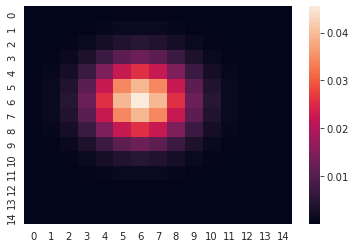

In [3]:
def gen_gauss_rf(D, width, center=(0,0)):
    # Generate gaussian blop (image) 
    sz = (D-1)/2
    x, y = sp.mgrid[-sz: sz + 1, -sz: sz + 1]
    x = x + center[0]
    y = y + center[1]
    w = np.exp(- (x ** 2/width + y ** 2 / width))
    w = w / np.sum(w.flatten())
    
    return w

w = gen_gauss_rf(15, 7, (1,1))
sns.heatmap(w)

In [4]:
def sample_lnp(w, nT, dt, R, v):
    '''Generate samples from an instantaneous LNP model neuron with 
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, ) 
        (flattened) receptive field kernel. 
    
    nT: int
        number of time steps
    
    dt: float
        duration of a frame in s
    
    R: float
        rate parameter
    
    v: float
        variance of the stimulus ensemble


    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins
    
    r: np.array, (nT, )
        mean rate in time bins
        
    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.

    '''
    
    np.random.seed(42)

    # sampled spike counts array
    c = np.empty(0) 
    # stimulus frames
    s = np.random.binomial(1,0.5, size=(w.shape[0], nT)) 
    # mean rate
    r = np.exp(w.T@s)*dt*R


    # Poisson spike counts 
    for i in r:
        c = np.append(c,np.random.poisson(lam=i))
    # ------------------------------------------------
    # Generate samples from an instantaneous LNP model 
    # neuron with receptive field kernel w. (0.5 pts)
    # ------------------------------------------------
    
    return c, r, s

In [5]:
D = 15     # number of pixels in one dimension, 
           # the simulated RF here is a square
nT = 1000  # number of time bins
dt = 0.1   # frame rate, 0.1s per bin. 
R = 50     # firing rate in Hz 
v = 5      # stimulus variance

w = gen_gauss_rf(D,7,(1,1))
w = w.flatten()

c, r, s = sample_lnp(w, nT, dt, R, v)

print(str(max(c))) 
### !!!Something is not right with sampling of c and r
### Values are too small

19.0


Plot the responses of the cell.

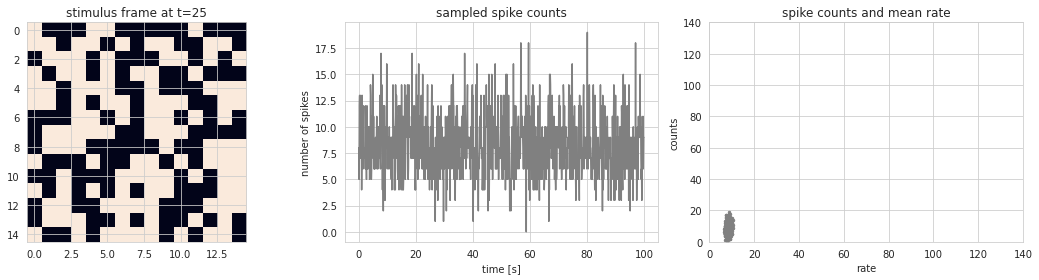

In [6]:
# insert your code here 

# --------------
# Plot (0.5 pts)
# --------------
t = np.arange(0,nT) * dt
#plt.figure(figsize=(15,4))

fig, axs = plt.subplots(1, 3,figsize=(15,4))
# ------------------------------------------------
# (1) one example frame from `s`; 
# ------------------------------------------------

axs[0].imshow(s[:,25].reshape((D,D)))
axs[0].set_title('stimulus frame at t=25')

# ------------------------------------------------
# (2) the simulated response `c`;
# ------------------------------------------------
axs[1].plot(t, c, color='grey')

axs[1].set_ylabel('number of spikes')
axs[1].set_xlabel('time [s]')
axs[2].set_ylim(0,140)
axs[1].set_xlim(-5,105)
axs[1].set_title('sampled spike counts')



# ------------------------------------------------
# (3) a scatter plot of `r` and `c`;
# ------------------------------------------------

axs[2].scatter(r,c,s=6,color = 'grey')
axs[2].set_ylabel('counts')
axs[2].set_xlabel('rate')
axs[2].set_xlim(0,140)
axs[2].set_ylim(0,140)
axs[2].set_title('spike counts and mean rate')




plt.tight_layout()
plt.show()

### Implementation 

Before you run your optimizer, make sure the gradient is correct. The helper function `check_grad` in `scipy.optimize` can help you do that. This package also has suitable functions for optimization. If you generate a large number of  samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [7]:
def negloglike_lnp(x, c, s, dt=0.1, R=50):
    '''Implements the negative (!) log-likelihood of the LNP model and its
    gradient with respect to the receptive field w.

    Parameters
    ----------

    x: np.array, (Dx * Dy, )
      current receptive field 

    c: np.array, (nT, )
      spike counts 

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at x
    
    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to x 
    '''
    f = -c@(x.T@s)
    a = np.sum(c*np.log(dt*R))
    b = np.sum(np.log(sp.special.factorial(c)))
    f += -a+b
    f += np.sum(np.exp(x.T@s)*dt*R)
  # gradient
    a = c@s.T
    b = dt*R*np.exp(x.T@s)
    df = -(a - b@s.T)
    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # and its gradient with respect to the receptive
    # field `w` using the simplified equantions you
    # calculated earlier. (0.5 pts)
    # ------------------------------------------------
       

    return f, df


Fit receptive field maximizing the log likelihood

In [8]:
###!! w_esti ist nicht richtig siehe plot!!!! ####

f, df = negloglike_lnp(w, c, s)


f = lambda w: negloglike_lnp(w, c, s)[0]
df = lambda w: negloglike_lnp(w, c, s)[1]

print(opt.check_grad(f,df,w))

w_rand = np.random.randint(2,size=(D*D))/1000
w_esti = opt.minimize(negloglike_lnp,w_rand,args=(c,s),jac=True).x
# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly, 
# minimizing the negative log-likelihood).
# 
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------


0.0018745414954674392


/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  
/home/v/anaconda3/envs/lit/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  from ipykernel import kernelapp as app


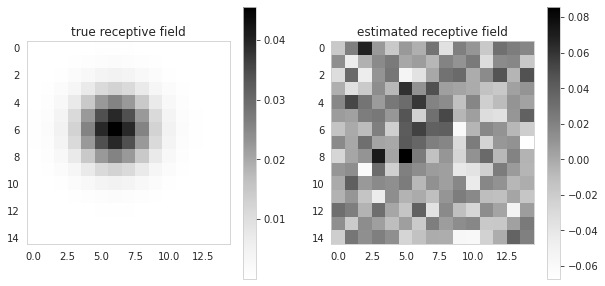

In [9]:
fig, axs = plt.subplots(1,2,figsize=(10,5))


p1=axs[0].imshow(w.reshape((D,D)), cmap='Greys')
axs[0].grid(False)
axs[0].set_title('true receptive field')

p2=axs[1].imshow(w_esti.reshape((D,D)), cmap='Greys')
axs[1].grid(False)
axs[1].set_title('estimated receptive field')


plt.tight_layout
plt.colorbar(p1,ax=axs[0])
plt.colorbar(p2,ax=axs[1])

# ------------------------------------
# Plot the ground truth and estimated 
# `w` side by side. (0.5 pts)
# ------------------------------------


## Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nda_ex_6_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 2 pts*


In [10]:
var = io.loadmat('./data/nda_ex_6_data.mat')

# t contains the spike times of the neuron
t = var['DN_spiketimes'].flatten()    

# trigger contains the times at which the stimulus flipped
trigger = var['DN_triggertimes'].flatten()

# contains the stimulus movie with black and white pixels
s = var['DN_stim']
s = s.reshape((300,1500)) # the shape of each frame is (20, 15)
s = s[:,1:len(trigger)]

Create vector of spike counts

In [11]:
c,b = np.histogram(t,bins=trigger)
# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------

Fit receptive field for each frame separately

In [12]:

nT = 1000
lags = np.arange(5)
res = s.shape[0]
D1 = 20
D2 = 15

w_rand = (np.random.uniform(0,1,size=res)/nT).flatten()
w_esti_lags = np.zeros((len(lags),res))

for l in lags:
  s_shift = s[:,:len(c)-l]
  w_esti_lags[l,:] = opt.minimize(negloglike_lnp,w_rand,args=(c[l:],s_shift),jac=True).x
    

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
# 
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------

Plot the frames one by one

<Figure size 720x288 with 0 Axes>

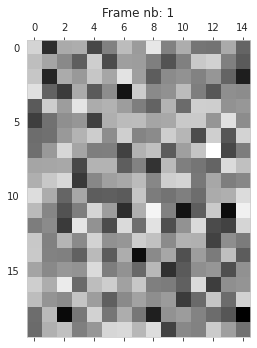

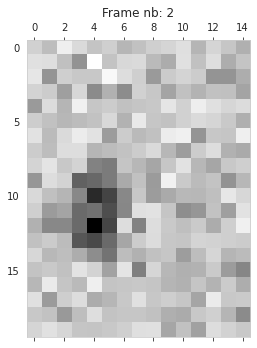

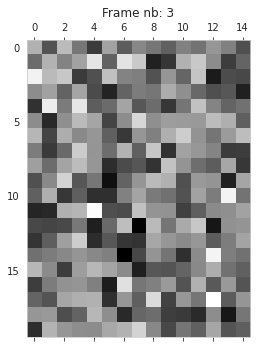

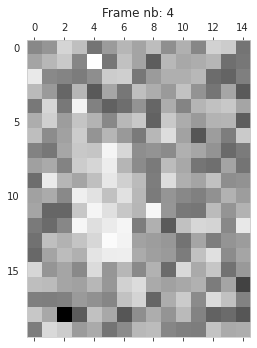

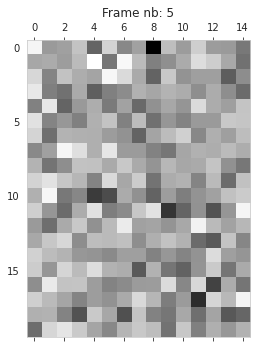

In [18]:
matfig = plt.figure(figsize=(10,4))


for i in lags:
  plt.matshow(w_esti_lags[i,:].reshape((D1,D2)), cmap='Greys')
  plt.grid(False)
  plt.title("Frame nb: " + str(i+1))
  #plt.tight_layout()
# --------------------------------------------
# Plot all 5 frames of the fitted RFs (0.5 pt)
# --------------------------------------------


## Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1 pts*

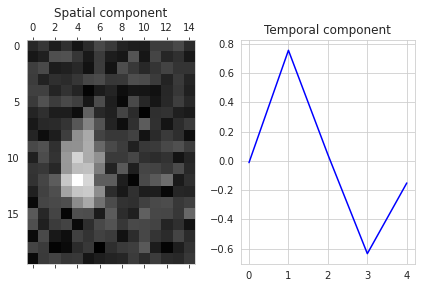

In [19]:
W = w_esti_lags
W = W - np.mean(w_esti_lags, axis=0)

u,_,vh = np.linalg.svd(W)

# temporal component
u1 = u[:,0]
# spatial component
v1 = vh[0,:] 
v1_spatial = v1.reshape(D1,D2)

fig, axs = plt.subplots(1,2, figsize=(6,4), squeeze=True)

axs[0].matshow(v1_spatial, cmap='gray')
axs[0].set_title("Spatial component")
axs[0].grid(False)

axs[1].plot(u1, color='blue')
axs[1].set_title("Temporal component")



plt.tight_layout()
plt.show()

# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------

# --------------------------------------------
# Plot the spatial and temporal components (0.5 pt)
# --------------------------------------------



## Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 2 pts*


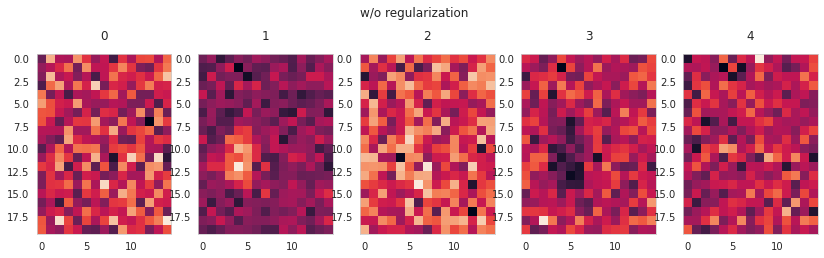

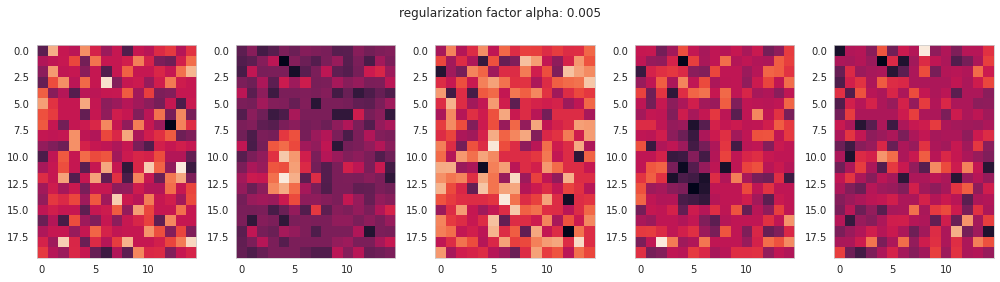

In [50]:
from sklearn import linear_model

alpha = 0.005
fig,axs = plt.subplots(1,len(lags),figsize=(14,4))
fig.suptitle('w/o regularization')
for i,l in enumerate(lags):
  colors = axs[i].imshow(w_esti_lags[l,:].reshape((D1,D2)))
  axs[i].set_title(str(l), pad = 15)
  axs[i].grid(False)


fig,ax = plt.subplots(1,len(lags),figsize=(14,4))
fig.suptitle('regularization factor alpha: '+str(alpha))

for i,l in enumerate(lags):
  model = linear_model.Lasso(alpha=alpha, selection="random")
  model.fit(s.T,c)

  w_lasso_lags = np.zeros((len(lags),res))
  #print(i)
  model.fit(s[:,:len(c)-l].T,c[l:]) 
  w_lasso_lags[l,:] = model.coef_
  ax[i].grid(False)
    
  colors = ax[i].imshow(w_lasso_lags[l,:].reshape((D1,D2)))
  plt.tight_layout()
      


# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before) 
# with sklern or pyglmnet (1 pt)
# ------------------------------------------

    

For alpha=0.01 the lasso estimation fits the estimated filter quite good. This does not noticably change with decreasing values for alpha. With a larger value for alpha the estimation gets less accurate.

In [49]:
# insert your code here 

# -------------------------------------------------
# Plot all 5 frames of the fitted RFs, compare them 
# with the ones without regularization (0.5 pt)
# -------------------------------------------------
